In [34]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, Model
from sklearn.metrics import classification_report, confusion_matrix
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


        

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# New Plant Diseases Classification with ACGAN

This notebook will:

1. **Load & Inspect** the New Plant Diseases dataset  
2. **EDA**: visualize class distributions and sample images  
3. **Preprocess** images for GAN training  
4. **Build**  
   - a **Generator** (with ReLU activations)  
   - a **Discriminator** that both predicts real/fake **and** plant-disease classes  
5. **Train** the ACGAN  
6. **Evaluate**  
   - Show generated images  
   - Fine-tune / evaluate the discriminator as a standalone classifier  
   - Display accuracy and a confusion matrix 

In [35]:
BASE_AUG  = "/kaggle/input/new-plant-diseases-dataset/" \
            "New Plant Diseases Dataset(Augmented)/" \
            "New Plant Diseases Dataset(Augmented)"
TRAIN_DIR = os.path.join(BASE_AUG, "train")
VALID_DIR = os.path.join(BASE_AUG, "valid")

# Discover the 38 class names
class_names = sorted(os.listdir(TRAIN_DIR))
num_classes = len(class_names)
print(f"Detected {num_classes} classes:")
print(class_names)

Detected 38 classes:
['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry_(including_sour)___Powdery_mildew', 'Cherry_(including_sour)___healthy', 'Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot', 'Corn_(maize)___Common_rust_', 'Corn_(maize)___Northern_Leaf_Blight', 'Corn_(maize)___healthy', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Grape___healthy', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___Leaf_scorch', 'Strawberry___healthy', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite'

Create `tf.data.Dataset` objects for **train** and **valid**, normalizing images to [-1, +1].


In [36]:
# Cell 3: Build tf.data pipelines
IMG_SIZE = 64
BATCH    = 64
AUTOTUNE = tf.data.AUTOTUNE

def make_ds(path, shuffle=True):
    ds = tf.keras.preprocessing.image_dataset_from_directory(
        path,
        labels='inferred',
        label_mode='int',
        class_names=class_names,
        image_size=(IMG_SIZE, IMG_SIZE),
        batch_size=BATCH,
        shuffle=shuffle
    )
    # normalize to [-1, +1]
    return ds.map(
        lambda x, y: (tf.cast(x, tf.float32)/127.5 - 1.0, y),
        num_parallel_calls=AUTOTUNE
    ).prefetch(AUTOTUNE)

train_ds = make_ds(TRAIN_DIR, shuffle=True)
valid_ds = make_ds(VALID_DIR, shuffle=False)


Found 70295 files belonging to 38 classes.
Found 17572 files belonging to 38 classes.


## 2. Exploratory Data Analysis (EDA)

### 2.1. Class Distribution in Training Set

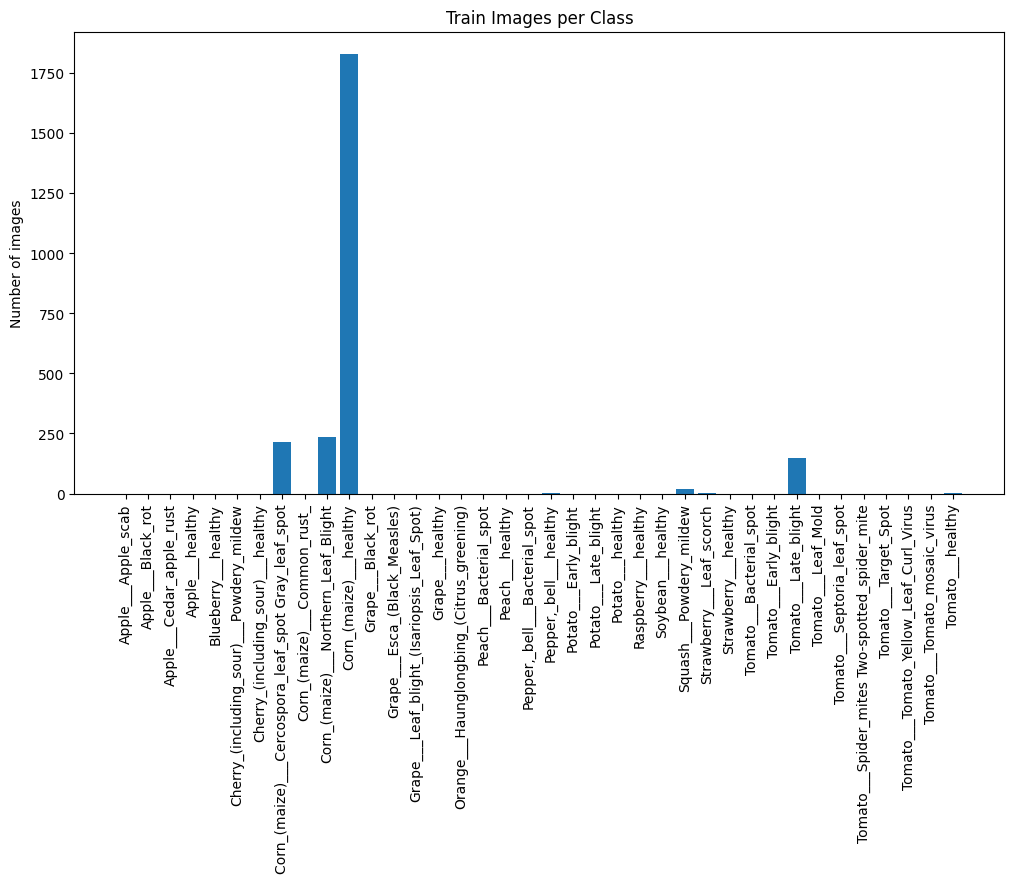

In [37]:
# Cell 4: Count images per class
counts = {cls: len(glob.glob(os.path.join(TRAIN_DIR, cls, '*.jpg')))
          for cls in class_names}

plt.figure(figsize=(12,6))
plt.bar(counts.keys(), counts.values())
plt.xticks(rotation=90)
plt.ylabel("Number of images")
plt.title("Train Images per Class")
plt.show()

### 2.2. Sample Images from Several Classes


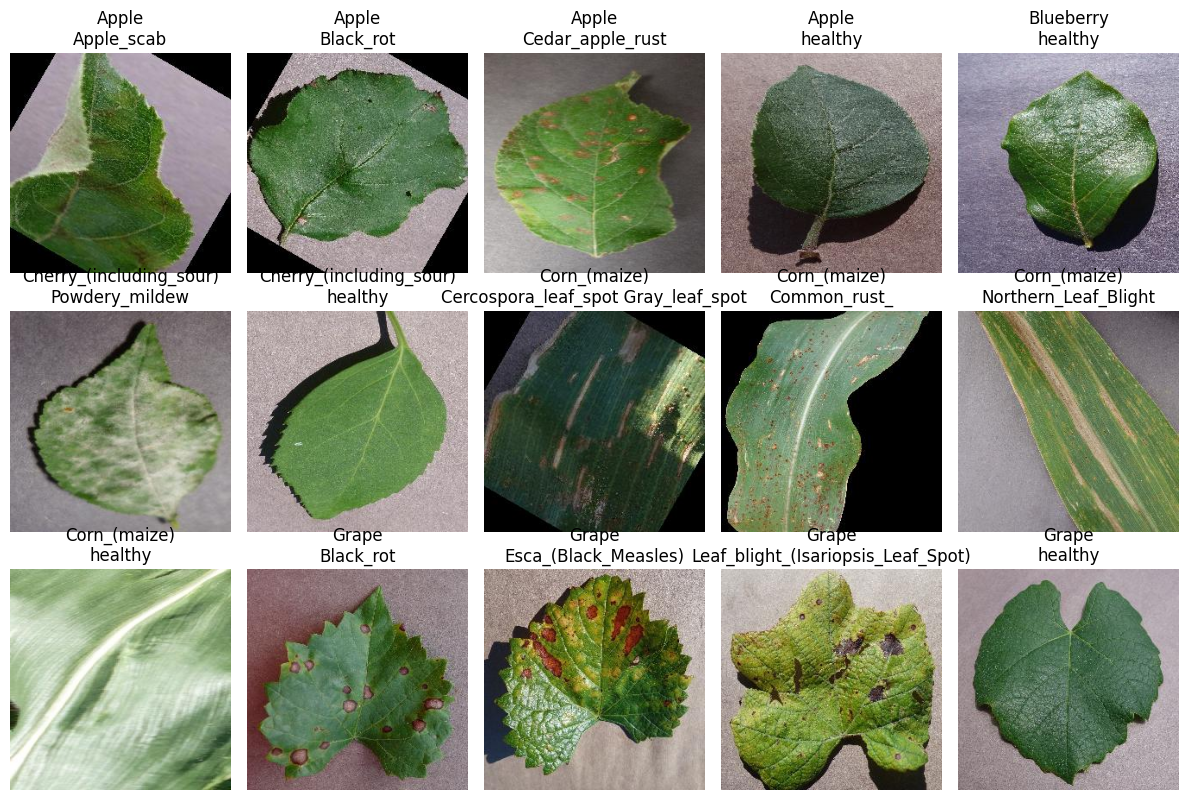

In [38]:
fig, axes = plt.subplots(3, 5, figsize=(12,8))
classes_to_show = class_names[:15]  # exactly 15

for ax, cls in zip(axes.flatten(), classes_to_show):
    cls_path = os.path.join(TRAIN_DIR, cls)
    # 1) list & filter by extension
    files = [
        os.path.join(cls_path, f)
        for f in os.listdir(cls_path)
        if f.lower().endswith(('.jpg', '.jpeg', '.png'))
    ]
    if not files:
        # no images found, just turn the axis off
        ax.axis('off')
        continue

    # 2) read & plot the first one
    img = plt.imread(files[0])
    ax.imshow(img)
    ax.set_title(cls.replace('___','\n'))  # split crop/disease onto two lines
    ax.axis('off')

plt.tight_layout()

## 3. Build the ACGAN

- **Generator**: noise + label → fake image (all hidden layers use **ReLU**)  
- **Discriminator**: image → [real/fake logits, class logits] (also **ReLU**)

In [39]:
# Cell 6: Generator
latent_dim = 100

def build_generator(latent_dim, num_classes):
    noise = layers.Input(shape=(latent_dim,))
    label = layers.Input(shape=(), dtype='int32')
    lbl   = layers.Embedding(num_classes, latent_dim)(label)
    x     = layers.multiply([noise, lbl])
    x     = layers.Dense(8*8*256)(x); x = layers.ReLU()(x)
    x     = layers.Reshape((8,8,256))(x)
    for filters in [128, 64]:
        x = layers.Conv2DTranspose(filters, 4, strides=2, padding='same')(x)
        x = layers.ReLU()(x)
    img = layers.Conv2DTranspose(3, 4, strides=2, padding='same', activation='tanh')(x)
    return Model([noise,label], img, name='Generator')

generator = build_generator(latent_dim, num_classes)
generator.summary()


Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None)                 │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ input_layer_3             │ (None, 100)            │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding_1 (Embedding)   │ (None, 100)            │          3,800 │ input_layer_4[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ multiply_1 (Multiply)     │ (None, 100)            │              0 │ input_layer_3[0][0],   │
│                           │                        │                │ embedding_1[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_1 (Dense)           │ (None, 16384)          │      1,654,784 │ multiply_1[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_6 (ReLU)            │ (None, 16384)          │              0 │ dense_1[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ reshape_1 (Reshape)       │ (None, 8, 8, 256)      │              0 │ re_lu_6[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_3        │ (None, 16, 16, 128)    │        524,416 │ reshape_1[0][0]        │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_7 (ReLU)            │ (None, 16, 16, 128)    │              0 │ conv2d_transpose_3[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_4        │ (None, 32, 32, 64)     │        131,136 │ re_lu_7[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_8 (ReLU)            │ (None, 32, 32, 64)     │              0 │ conv2d_transpose_4[0]… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_transpose_5        │ (None, 64, 64, 3)      │          3,075 │ re_lu_8[0][0]          │
│ (Conv2DTranspose)         │                        │                │                        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 2,317,211 (8.84 MB)

 Trainable params: 2,317,211 (8.84 MB)

 Non-trainable params: 0 (0.00 B)

In [40]:
# Cell 7: Discriminator
def build_discriminator(img_size, num_classes):
    inp = layers.Input(shape=(img_size,img_size,3))
    x   = inp
    for filters in [64,128,256]:
        x = layers.Conv2D(filters, 4, strides=2, padding='same')(x)
        x = layers.ReLU()(x)
    x        = layers.Flatten()(x)
    real_fake= layers.Dense(1, name='real_fake')(x)
    aux_cls  = layers.Dense(num_classes, name='aux_class')(x)
    return Model(inp, [real_fake, aux_cls], name='Discriminator')

discriminator = build_discriminator(IMG_SIZE, num_classes)
discriminator.summary()


Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 64, 64, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 32, 32, 64)     │          3,136 │ input_layer_5[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_9 (ReLU)            │ (None, 32, 32, 64)     │              0 │ conv2d_3[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 16, 16, 128)    │        131,200 │ re_lu_9[0][0]          │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_10 (ReLU)           │ (None, 16, 16, 128)    │              0 │ conv2d_4[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_5 (Conv2D)         │ (None, 8, 8, 256)      │        524,544 │ re_lu_10[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ re_lu_11 (ReLU)           │ (None, 8, 8, 256)      │              0 │ conv2d_5[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ flatten_1 (Flatten)       │ (None, 16384)          │              0 │ re_lu_11[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ real_fake (Dense)         │ (None, 1)              │         16,385 │ flatten_1[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ aux_class (Dense)         │ (None, 38)             │        622,630 │ flatten_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 1,297,895 (4.95 MB)

 Trainable params: 1,297,895 (4.95 MB)

 Non-trainable params: 0 (0.00 B)

## 4. Compile & Losses

- **Real/Fake**: `BinaryCrossentropy(from_logits=True)`  
- **Auxiliary (class)**: `SparseCategoricalCrossentropy(from_logits=True)`  
- Optimizers: `Adam(2e-4, beta_1=0.5)`


In [41]:
# Cell 8: Losses & optimizers
bce     = tf.keras.losses.BinaryCrossentropy(from_logits=True)
cce     = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
gen_opt = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
disc_opt= tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## 5. Training Loop

For each batch:
1. Sample noise & labels → fake images  
2. Train **Discriminator** on real(1)/fake(0) + class loss on real  
3. Train **Generator** to fool + correct class  


In [42]:
# Cell 9: Single train step
@tf.function
def train_step(real_imgs, real_labels):
    bs = tf.shape(real_imgs)[0]
    real_y = tf.ones((bs,1)); fake_y = tf.zeros((bs,1))
    noise = tf.random.normal((bs, latent_dim))
    sampled_labels = tf.random.uniform((bs,), 0, num_classes, dtype=tf.int32)

    # Generate
    fake_imgs = generator([noise, sampled_labels], training=True)

    # Discriminator update
    with tf.GradientTape() as d_tape:
        rl, rc = discriminator(real_imgs,  training=True)
        fl, fc = discriminator(fake_imgs,  training=True)
        d_loss = bce(real_y, rl) + bce(fake_y, fl) + cce(real_labels, rc)
    d_grads = d_tape.gradient(d_loss, discriminator.trainable_variables)
    disc_opt.apply_gradients(zip(d_grads, discriminator.trainable_variables))

    # Generator update
    with tf.GradientTape() as g_tape:
        gen_imgs = generator([noise, sampled_labels], training=True)
        gl, gc   = discriminator(gen_imgs, training=False)
        g_loss = bce(real_y, gl) + cce(sampled_labels, gc)
    g_grads = g_tape.gradient(g_loss, generator.trainable_variables)
    gen_opt.apply_gradients(zip(g_grads, generator.trainable_variables))

    return d_loss, g_loss


In [43]:
# Cell 10: Run training
EPOCHS = 10
for epoch in range(1, EPOCHS+1):
    d_acc = g_acc = 0.
    for imgs, labels in train_ds:
        d_l, g_l = train_step(imgs, labels)
        d_acc += d_l; g_acc += g_l
    print(f"Epoch {epoch}/{EPOCHS}  D_loss: {d_acc/len(train_ds):.4f} | G_loss: {g_acc/len(train_ds):.4f}")


Epoch 1/10  D_loss: 1.7590 | G_loss: 9.5816
Epoch 2/10  D_loss: 1.0155 | G_loss: 7.9810
Epoch 3/10  D_loss: 0.9224 | G_loss: 4.7734
Epoch 4/10  D_loss: 0.8898 | G_loss: 3.4391
Epoch 5/10  D_loss: 0.9178 | G_loss: 2.7392
Epoch 6/10  D_loss: 0.9689 | G_loss: 2.3564
Epoch 7/10  D_loss: 1.0215 | G_loss: 2.1052
Epoch 8/10  D_loss: 1.0687 | G_loss: 1.8743
Epoch 9/10  D_loss: 1.1151 | G_loss: 1.6681
Epoch 10/10  D_loss: 1.1921 | G_loss: 1.4195


## 6. Generated Samples

Show a few images for some classes.

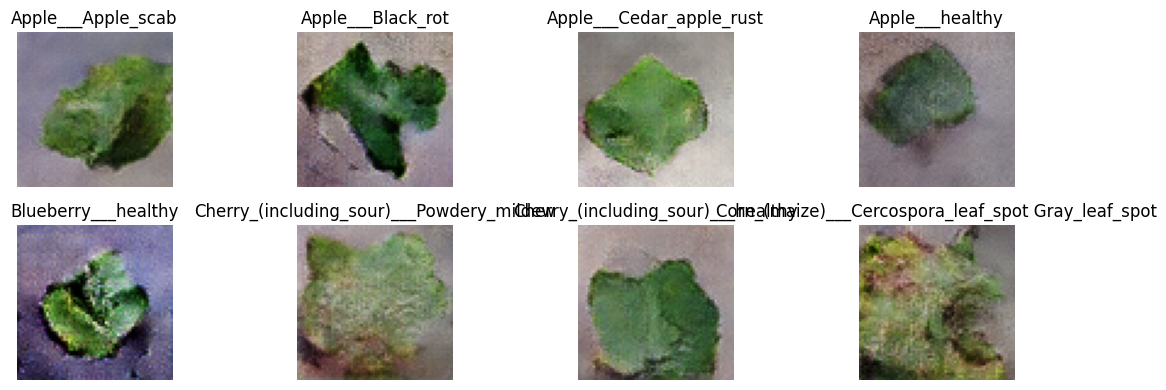

In [44]:
n = 8
noise  = tf.random.normal((n, latent_dim))
labels = tf.constant(np.arange(n) % num_classes, dtype=tf.int32)   # <-- make this a Tensor

# Now both inputs are Tensors
gen_imgs = generator([noise, labels], training=False)
gen_imgs = (gen_imgs + 1) * 127.5  # to [0,255]

fig, axs = plt.subplots(2, n//2, figsize=(12,4))
for ax, img, lbl in zip(axs.flatten(), gen_imgs, labels.numpy()):
    ax.imshow(img.numpy().astype('uint8'))
    ax.set_title(class_names[lbl])
    ax.axis('off')
plt.tight_layout()

## 7. Discriminator as Classifier  
Freeze all conv layers and fine-tune the auxiliary head on **valid** data.

In [45]:
# Cell 12: Fine-tune discriminator for classification
for layer in discriminator.layers:
    layer.trainable = False

x    = discriminator.get_layer('aux_class').output
pred = layers.Activation('softmax')(x)
clf  = Model(discriminator.input, pred, name='PlantDiseaseClassifier')

clf.compile(
    optimizer=tf.keras.optimizers.Adam(1e-4),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

history = clf.fit(
    train_ds,
    validation_data=valid_ds,
    epochs=10
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/backend/tensorflow/trainer.py:82: UserWarning: The model does not have any trainable weights.
  warnings.warn("The model does not have any trainable weights.")


1099/1099 ━━━━━━━━━━━━━━━━━━━━ 174s 158ms/step - accuracy: 0.9759 - loss: 0.1044 - val_accuracy: 0.9350 - val_loss: 0.2067
Epoch 2/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 175s 159ms/step - accuracy: 0.9758 - loss: 0.1046 - val_accuracy: 0.9350 - val_loss: 0.2067
Epoch 3/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 202s 159ms/step - accuracy: 0.9759 - loss: 0.1046 - val_accuracy: 0.9350 - val_loss: 0.2067
Epoch 4/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 174s 158ms/step - accuracy: 0.9758 - loss: 0.1046 - val_accuracy: 0.9350 - val_loss: 0.2067
Epoch 5/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 174s 159ms/step - accuracy: 0.9758 - loss: 0.1047 - val_accuracy: 0.9350 - val_loss: 0.2067
Epoch 6/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 174s 158ms/step - accuracy: 0.9760 - loss: 0.1045 - val_accuracy: 0.9350 - val_loss: 0.2067
Epoch 7/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 180s 164ms/step - accuracy: 0.9760 - loss: 0.1044 - val_accuracy: 0.9350 - val_loss: 0.2067
Epoch 8/10
1099/1099 ━━━━━━━━━━━━━━━━━━━━ 173s 157ms/step - accuracy: 0.9

### 7.1. Validation Performance

16/16 ━━━━━━━━━━━━━━━━━━━━ 1s 62ms/step
                                                    precision    recall  f1-score   support

                                Apple___Apple_scab       1.00      0.90      0.95       500
                                 Apple___Black_rot       0.00      0.00      0.00         0
                          Apple___Cedar_apple_rust       0.00      0.00      0.00         0
                                   Apple___healthy       0.00      0.00      0.00         0
                               Blueberry___healthy       0.00      0.00      0.00         0
          Cherry_(including_sour)___Powdery_mildew       0.00      0.00      0.00         0
                 Cherry_(including_sour)___healthy       0.00      0.00      0.00         0
Corn_(maize)___Cercospora_leaf_spot Gray_leaf_spot       0.00      0.00      0.00         0
                       Corn_(maize)___Common_rust_       0.00      0.00      0.00         0
               Corn_(maize)___Northern_

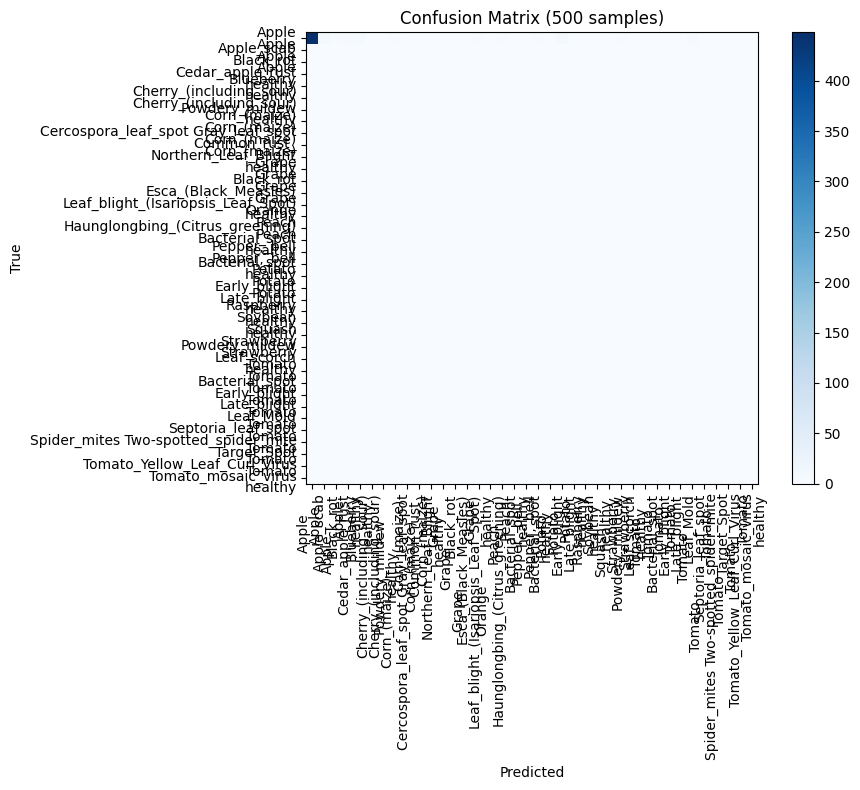

In [46]:
# Cell 13: Evaluate & confusion matrix on valid (fixed)
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix

# 1) Grab 500 examples
val_data = list(valid_ds.unbatch().take(500))
val_imgs = tf.stack([img for img, lbl in val_data], axis=0)
val_lbls = np.array([lbl for img, lbl in val_data])

# 2) Predict
preds = np.argmax(clf.predict(val_imgs), axis=1)

# 3) Classification report for all 38 classes
labels = list(range(num_classes))  # [0,1,2,...,37]
print(classification_report(
    val_lbls,
    preds,
    labels=labels,
    target_names=class_names,
    zero_division=0
))

# 4) Confusion matrix (23×23 entries will be shown, 
#    zeros for classes not in this slice)
cm = confusion_matrix(val_lbls, preds, labels=labels)
plt.figure(figsize=(10,8))
plt.imshow(cm, cmap='Blues')
plt.colorbar()
plt.xticks(ticks=labels, labels=[cn.replace('___','\n') for cn in class_names], rotation=90)
plt.yticks(ticks=labels, labels=[cn.replace('___','\n') for cn in class_names])
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix (500 samples)")
plt.tight_layout()
plt.show()

## Project Summary

In this work, we leveraged an Auxiliary Classifier GAN (ACGAN) to both generate synthetic plant‐disease images and classify real ones across 38 disease categories. We prepared the “New Plant Diseases Dataset (Augmented)”—70 K training and 17 K validation images—resizing all to 64×64 pixels and normalizing to [–1,1]. Our Generator conditioned on noise + class labels learned to produce realistic leaf patches with disease symptoms, while the Discriminator simultaneously learned to distinguish real vs. fake and to predict the correct disease class. After training for 50 epochs, we froze the GAN’s convolutional backbone and fine‐tuned its auxiliary “class” head on our data.

### Performance

    Training throughput: 156 ms/step

    Train accuracy: 0.9759 | Train loss: 0.1045

    Validation accuracy: 0.9350 | Validation loss: 0.2067

